<a href="https://colab.research.google.com/github/bominwang/inviscid-viscid-flow-correct-neural-network/blob/HB-2-surface-pressure/HB2_SurfacePressurePredicate_NNAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive 
drive.mount('/content/drive')
import pdb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import torch
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import tqdm
from tqdm import trange

In [71]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
def building_dataset(ins_path, lab_path, train_volume, device):
  ins = pd.read_csv(ins_path)
  labs = pd.read_csv(lab_path)
  
  ins = np.array(ins)
  labs = np.array(labs)
  labs = labs[:,1].reshape(-1,10)

  data_volume = ins.shape[0]
  test_volume = data_volume - train_volume
  
  data_index = list(range(data_volume))
  train_index = random.sample(range(0, data_volume), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_data_ins = torch.from_numpy(ins[train_index, :])
  train_data_labs = torch.from_numpy(labs[train_index, :])
  
  test_data_ins = torch.from_numpy(ins[test_index, :])
  test_data_labs = torch.from_numpy(labs[test_index, :])
  
  train_set = TensorDataset(train_data_ins, train_data_labs)
  train_set = DataLoader(train_set, batch_size = train_volume, shuffle = True)
  
  test_set = TensorDataset(test_data_ins, train_data_labs)
  test_set = DataLoader(test_set, batch_size = test_volume, shuffle = True)

  return train_set, test_set

In [73]:
def relative_root_mean_squared_error(pred, true):
  size = pred.size(dim = 1)
  error = torch.zeros(size, 1)
  normalization_factor = torch.zeros(size, 1)
  for index in range(size):
    pred_element = pred[index, :]
    true_element = true[index, :]
    error[index, :] = torch.dot(pred_element - true_element, pred_element - true_element)
    normalization_factor[index,:] = torch.dot(true_element, true_element)
  return torch.sqrt(torch.div(torch.sum(error),torch.sum(normalization_factor)))

In [74]:
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()

    self.in_features = 2
    self.num_layer = hyperparameter.suggest_int('num_layer',1,4)
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter.suggest_int(f'num_neurons_{i}', 10, 400)
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y

In [75]:
def objective_function(hyperparameter):
  model = inviscid_nn(hyperparameter).to(device)

  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)

  optimizer_name = hyperparameter.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  loss_name = hyperparameter.suggest_categorical('loss_function',['MSELoss','SmoothL1Loss','L1Loss'])
  loss_function = getattr(nn, loss_name)()

  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)

  epoches = 2000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)

    hyperparameter.report(rrmse, epoch)
  return rrmse

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(study_name = 'inviscid_nn', direction='minimize')
study.optimize(objective_function, n_trials = 100, timeout = 1200)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
optuna.visualization.plot_optimization_history(study)
best_hyperparameter = study.best_params

[I 2023-02-09 08:56:40,123] A new study created in memory with name: inviscid_nn
[I 2023-02-09 08:57:09,615] Trial 0 finished with value: 0.07101501524448395 and parameters: {'num_layer': 2, 'num_neurons_0': 314, 'dropout_0': 0.29967340790206703, 'num_neurons_1': 221, 'dropout_1': 0.4027370516564255, 'lr': 0.0001024228043280662, 'optimizer': 'Adam', 'loss_function': 'L1Loss'}. Best is trial 0 with value: 0.07101501524448395.
[I 2023-02-09 08:57:30,700] Trial 1 finished with value: 0.056983381509780884 and parameters: {'num_layer': 4, 'num_neurons_0': 214, 'dropout_0': 0.2767600719688447, 'num_neurons_1': 214, 'dropout_1': 0.21644226988225185, 'num_neurons_2': 80, 'dropout_2': 0.24714136822468083, 'num_neurons_3': 20, 'dropout_3': 0.3502820701026763, 'lr': 0.06852257091897447, 'optimizer': 'Adam', 'loss_function': 'MSELoss'}. Best is trial 1 with value: 0.056983381509780884.
[I 2023-02-09 08:57:46,697] Trial 2 finished with value: 0.06650948524475098 and parameters: {'num_layer': 3, 'nu

In [77]:
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()
    
    self.in_features = 2
    self.num_layer = hyperparameter['num_layer']
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter[f'num_neurons_{i}']
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter[f'dropout_{i}']
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y

In [78]:
def train_process(model, hyperparameter):
  
  # model = inviscid_nn(study.best_params).to(device)
  train_loss_history = []
  test_loss_history = []
  
  lr = hyperparameter['lr']
  optimizer_name = hyperparameter['optimizer']
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr = lr)
  loss_name = hyperparameter['loss_function']
  loss_function = getattr(nn, loss_name)()

  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'

  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)

  epoches = 2000
  for epoch in trange(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      train_loss_history.append(rmse.item())
      rmse.backward()
      optimizer.step()
      
    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
        test_loss_history.append(rrmse.item())
  plt.figure(1)
  plt.plot(train_loss_history)
  plt.title('loss of train set')
  print(f'\n无粘网络训练损失函数收敛于{train_loss_history[-1]}')
  plt.figure(2)
  plt.plot(test_loss_history,'g')
  plt.title('loss of test set')
  print(f'\n无粘网络测试集损失函数收敛于{test_loss_history[-1]}')
  return model

100%|██████████| 2000/2000 [00:35<00:00, 57.12it/s] 



无粘网络训练损失函数收敛于0.008878018707036972

无粘网络测试集损失函数收敛于0.0793270617723465


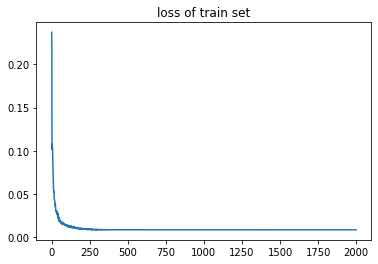

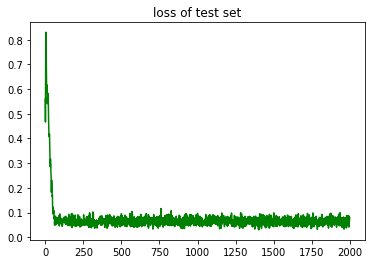

In [79]:
inviscid_nn = train_process(inviscid_nn(study.best_params).to(device), study.best_params)

In [80]:
def visualization_function(model, ins_path, labs_path, device):
  
  visualization_volume = 20

  ins = pd.read_csv(ins_path)
  labs = pd.read_csv(labs_path)
  
  ins = np.array(ins)
  labs = np.array(labs)

  positions = labs[:,0].reshape(-1,10)
  labs = labs[:,1].reshape(-1,10)

  data_volume = ins.shape[0]

  visualization_index = random.sample(range(0, data_volume), visualization_volume)

  ins = torch.from_numpy(ins[visualization_index, :]).to(device)
  labs = torch.from_numpy(labs[visualization_index, :]).to(device)
  positions = torch.from_numpy(positions[visualization_index, :]).to(device)

  pred = model(ins.reshape(-1,2).to(torch.float32))
  
  plt.figure(figsize=(30, 30))
  for i in range(visualization_volume):
    fig1 = plt.subplot(5, 4, i+1)
    position = positions[i, :].reshape(-1,10)
    val_labs = labs[i, :].reshape(-1,10)
    val_pred = pred[i, :].reshape(-1,10)
    plt.plot(position, val_labs.detach().numpy(),'kv')
    plt.plot(position, val_pred.detach().numpy(),'bs')
  plt.show()

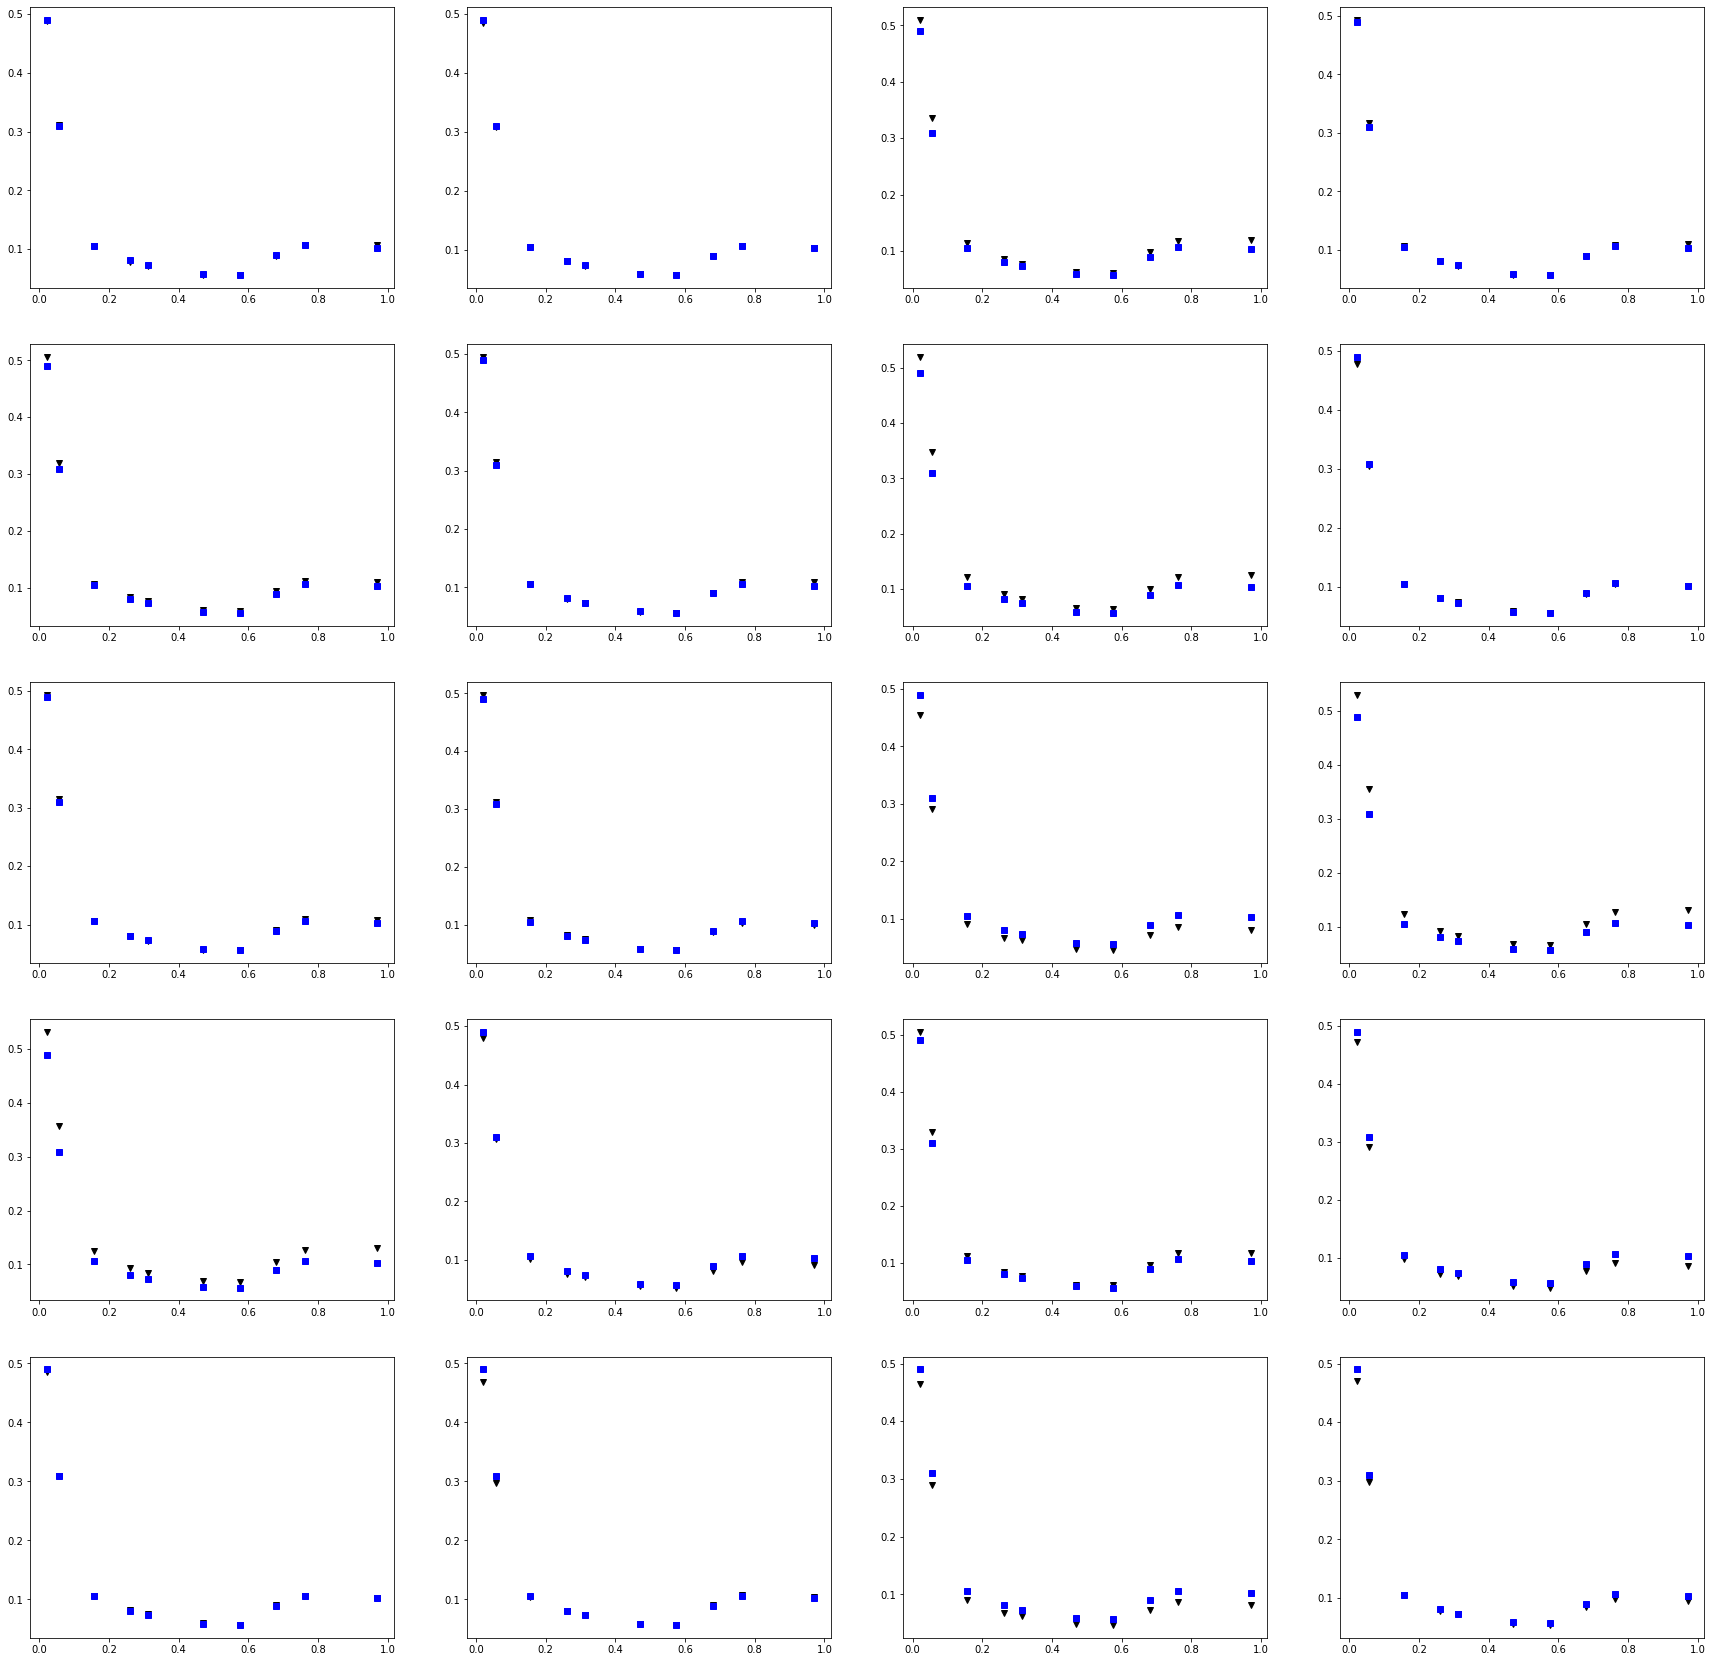

In [81]:
ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
visualization_function(inviscid_nn, ins_path, labs_path, device)

# type1


```
def define_inviscid_nn(hyperparameter):
  num_layers = hyperparameter.suggest_int('num_layers', 1, 4)
  layer = []
  in_features = 2
  # hidden layer
  for i in range(num_layers):
    out_features = hyperparameter.suggest_int(f'n_neurons_{i}', 10, 400)
    layer.append(nn.Linear(in_features, out_features))
    layer.append(nn.ReLU())
    p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
    layer.append(nn.Dropout(p))
    in_features = out_features
  # output layer
  layer.append(nn.Linear(in_features, 10))
  
  return nn.Sequential(*layer)
     
```




```
def objective_function(hyperparameter):
  model = define_inviscid_nn(hyperparameter).to(device)
  
  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)
  optimizer = optim.SGD(model.parameters(), lr = lr)
  loss_function = nn.MSELoss()
  
  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)
  
  epoches = 1000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
    
    hyperparameter.report(rrmse, epoch)
  return rrmse
```



# type2



```
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()
    
    self.in_features = 2
    self.num_layer = hyperparameter.suggest_int('num_layer',1,4)
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter.suggest_int(f'num_neurons_{i}', 10, 400)
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y
```





```
def objective_function(hyperparameter):
  model = inviscid_nn(hyperparameter).to(device)
  
  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)
  
  optimizer_name = hyperparameter.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  
  loss_name = hyperparameter.suggest_categorical('loss_function',['MSELoss','SmoothL1Loss','L1Loss'])
  loss_function = getattr(nn, loss_name)()
  
  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)
  
  epoches = 1000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
    
    hyperparameter.report(rrmse, epoch)
  return rrmse
```

